In [1]:
!pip install -qq emoji
!pip install -qq ekphrasis
!pip install -qq datasets

     |████████████████████████████████| 174 kB 4.9 MB/s 
     |████████████████████████████████| 80 kB 3.5 MB/s 
     |████████████████████████████████| 43 kB 973 kB/s 
     |████████████████████████████████| 53 kB 1.4 MB/s 
     |████████████████████████████████| 311 kB 5.1 MB/s 
     |████████████████████████████████| 67 kB 3.8 MB/s 
     |████████████████████████████████| 133 kB 17.1 MB/s 
     |████████████████████████████████| 1.1 MB 52.5 MB/s 
     |████████████████████████████████| 243 kB 55.1 MB/s 
     |████████████████████████████████| 271 kB 49.5 MB/s 
     |████████████████████████████████| 144 kB 51.8 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 


In [2]:

   
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
#from transformers import BertTokenizer
import string 
import re
import spacy
nlp2 = spacy.load('en_core_web_sm')
from spacy.symbols import ORTH,NORM,LEMMA
import string 
from spacy.lang.char_classes import LIST_PUNCT, LIST_ELLIPSES, LIST_QUOTES, LIST_CURRENCY
from spacy.lang.char_classes import LIST_ICONS, HYPHENS, CURRENCY, UNITS
from spacy.lang.char_classes import CONCAT_QUOTES, ALPHA_LOWER, ALPHA_UPPER, ALPHA, PUNCT
from spacy.util import compile_infix_regex, compile_prefix_regex, compile_suffix_regex
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import emoji as emoji
import string
import matplotlib.pyplot as plt
import imblearn
from imblearn.over_sampling import RandomOverSampler
import datasets
from datasets import Dataset

In [3]:
twitter_df= pd.read_csv('/content/drive/MyDrive/Dissertation/labeled_data.csv')


In [4]:
twitter_df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [5]:
print(twitter_df.shape)

(24783, 7)


In [6]:

unanimous_hate_votes = len(twitter_df[twitter_df["class"]==0] [twitter_df["count"] == twitter_df["hate_speech"]  ])
unanimous_offensive_votes = len(twitter_df[twitter_df["class"]==1] [twitter_df["count"] == twitter_df["offensive_language"]  ])
unanimous_neither_votes = len(twitter_df[twitter_df["class"]==2] [twitter_df["count"] == twitter_df["neither"]  ])


print("Unanimous Hate Votes: ", unanimous_hate_votes)
print("Unanimous Offensive Votes: ", unanimous_offensive_votes)
print("Unanimous Neither Votes: ", unanimous_neither_votes)

Unanimous Hate Votes:  263
Unanimous Offensive Votes:  14347
Unanimous Neither Votes:  2872


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [7]:
twitter_df = twitter_df[['class','tweet']]


In [8]:
##### text preprocessor for ekphrasis
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    # terms that will be annotated
    fix_html=True,  # fix HTML tokens
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [9]:
#input: text
#process: ekphrasis preprocesser + some extra processing  
#output: list of tokens      
def ek_extra_preprocess(text):
    remove_words=['<allcaps>','</allcaps>','<hashtag>','</hashtag>','<elongated>','<emphasis>','<repeated>','\'','s']
    word_list=text_processor.pre_process_doc(text)
    word_list=list(filter(lambda a: a not in remove_words, word_list)) 
    word_list=[token for token in word_list if token not in string.punctuation]
    return " ".join(word_list)



In [10]:
twitter_df['tweet_clean'] = twitter_df['tweet'].apply(ek_extra_preprocess)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
twitter_df[twitter_df["class"]==0].head(25)

,class,tweet,tweet_clean
85,0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...",<user> <user> <user> queer gaywad
89,0,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ...",<user> <user> alsarabss hes a beaner smh you c...
110,0,"""@DevilGrimz: @VigxRArts you're fucking gay, b...",<user> <user> you are fucking gay blacklisted ...
184,0,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL...",<user> lmfao i hate black people <url> this is...
202,0,"""@NoChillPaz: ""At least I'm not a nigger"" http...",<user> at least i am not a nigger <url> lmfao
204,0,"""@NotoriousBM95: @_WhitePonyJr_ Ariza is a sna...",<user> <user> ariza is a snake and a coward bu...
219,0,"""@RTNBA: Drakes new shoes that will be release...",<user> drakes new shoes that will be released ...
260,0,"""@TheoMaxximus: #GerrysHalloweenParty http://t...",<user> gerrys halloween party <url> halloween ...
312,0,"""@ashlingwilde: @ItsNotAdam is bored supposed ...",<user> <user> is bored supposed to be cute you...
315,0,"""@bigbootybishopp: @white_thunduh lassen cc , ...",<user> <user> lassen cc the coach wants me i f...


In [12]:
twitter_df['words_clean'] = twitter_df['tweet_clean'].apply(lambda x: len(x.split()))
twitter_df['words'] = twitter_df['tweet'].apply(lambda x: len(x.split())) 

print("Min")
print(twitter_df[['words']].min())
print("Max")
print(twitter_df[['words']].max())

Min
words    1
dtype: int64
Max
words    52
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
twitter_df.sort_values(by='words',ascending=False).head(20)

,class,tweet,tweet_clean,words_clean,words
22478,2,Was finna slit my eyebrows up in the shop but ...,was finna slit my eyebrows up in the shop but nah,11,52
2099,1,"' She herd I was a dope boy , I herd she was a...",she herd i was a dope boy i herd she was a gol...,31,36
19115,1,RT @hspiotta_21: c is for cunt\nu is for ur a ...,rt <user> c is for cunt u is for ur a cunt n i...,33,33
11158,1,I'd shut the fuck up or I'll just be wide and ...,i d shut the fuck up or i will just be wide an...,35,33
13699,1,"Oomf a hoe. She know she a hoe, I know she a h...",oomf a hoe she know she a hoe i know she a hoe...,34,33
23174,1,Yo bitch a freak fucked ha to sleep and dat wa...,yo bitch a freak fucked ha to sleep and dat wa...,32,33
11383,1,"I'm sippin on Patron nigga , my bitch bad to t...",i am sippin on patron nigga my bitch bad to th...,28,33
10377,1,I got no pic up lines I stay on my grind I tel...,i got no pic up lines i stay on my grind i tel...,31,33
20970,2,"So my light was off &amp; door was closed , mo...",so my light was off door was closed mom walks ...,28,32
10089,1,I broke baby outta his thug stage n turned him...,i broke baby outta his thug stage n turned him...,33,32


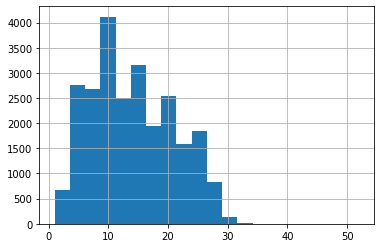

In [14]:
twitter_df['words'].hist(bins=20)

In [15]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters="")
tokenizer.fit_on_texts(twitter_df['tweet_clean'])
print("Unique tokens:", len(tokenizer.word_index))

Unique tokens: 18889


In [16]:
word_index = tokenizer.word_index
words_array = np.empty(len(word_index)).astype(str)
for key,value in word_index.items():
  words_array[value-1] = key

In [17]:
def count (corpus):
  
  word_frequency = np.zeros(len(word_index))
  doc_frequency = np.zeros(len(word_index))
  for text in corpus:
    wordlist = text.split()
    wordfreq = [wordlist.count(p) for p in wordlist]
    for key,value in dict(list(zip(wordlist,wordfreq))).items():
       index = word_index.get(key) 
       if not (index is None):
          word_frequency[index-1] = word_frequency[index-1]+value
          doc_frequency[index-1] = doc_frequency[index-1]+1
       else:
          print(key)
  
  return word_frequency,doc_frequency



In [18]:
word_freq, doc_freq = count(twitter_df['tweet_clean'])


In [19]:
words = pd.DataFrame(columns=['Word','WordFreq','DocFreq'])
words['Word'] = words_array
words['WordFreq'] = word_freq
words['DocFreq'] = doc_freq
words.head()

,Word,WordFreq,DocFreq
0,<user>,19280.0,14189.0
1,<number>,17301.0,7016.0
2,i,9834.0,7388.0
3,a,9567.0,7683.0
4,bitch,8363.0,7899.0


In [20]:

twitter_df = twitter_df.drop(['tweet','words','words_clean'],axis=1)
twitter_df = twitter_df.rename(columns={"tweet_clean":"sentence", "class":"label"})




In [21]:

twitter_hf_df = Dataset.from_pandas(twitter_df)
twitter_dataset_dfs = twitter_hf_df.train_test_split(test_size=0.2)
twitter_dataset_dfs.save_to_disk('/content/drive/MyDrive/Dissertation/twitter_dfs.csv')


Flattening the indices:   0%|          | 0/20 [00:00<?, ?ba/s]

Flattening the indices:   0%|          | 0/5 [00:00<?, ?ba/s]

In [22]:
twitter_df

,label,sentence
0,2,rt <user> as a woman you should not complain a...
1,1,rt <user> boy dats cold tyga dwn bad for cuffi...
2,1,rt <user> dawg rt <user> you ever fuck a bitch...
3,1,rt <user> <user> she look like a tranny
4,1,rt <user> the shit you hear about me might be ...
...,...,...
24778,1,you a muthaf***in <censored> lie <number> <use...
24779,2,you have gone and broke the wrong heart baby a...
24780,1,young buck wanna eat dat nigguh like i aint fu...
24781,1,youu got wild bitches tellin you lies


In [24]:
ros = RandomOverSampler(sampling_strategy={0: 4000, 1:19190,2:4163})


twitter_ros, y_ros = ros.fit_resample(twitter_df, twitter_df['label'])

twitter_ros_dfs = Dataset.from_pandas(twitter_ros)
twitter_ros_dfs.save_to_disk('/content/drive/MyDrive/Dissertation/twitter_ros_dfs.csv')
